# NLP & ML
## Use case : sentiment analysis (IMDB MovieReviews)
Links : 
- https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data
- http://files.grouplens.org/datasets/movielens/

<ol>
  <li><a href='#section1'>Library import</a></li>
  <li><a href='#section2'>Snowpark connexion</a></li>
  <li><a href='#section3'>Training model</a></li>
  <li><a href='#section4'>Push the train into Snowflake using a Store Procedure</a></li>
  <li><a href='#section44'>Call the Store Procedure to train the model</a></li>
  <li><a href='#section5'>Deploy an UDF for prediction</a></li>

<!--
      <ul>
          <li><a href='#section61'>Parameters</a></li>
          <li><a href='#section62'>Representation (Sparse Matrice)</a></li>
      </ul>
-->
  <li><a href='#section6'>Prediction</a></li>
  <li><a href='#section7'>Push the prediction into Snowflake</a></li>
</ol>

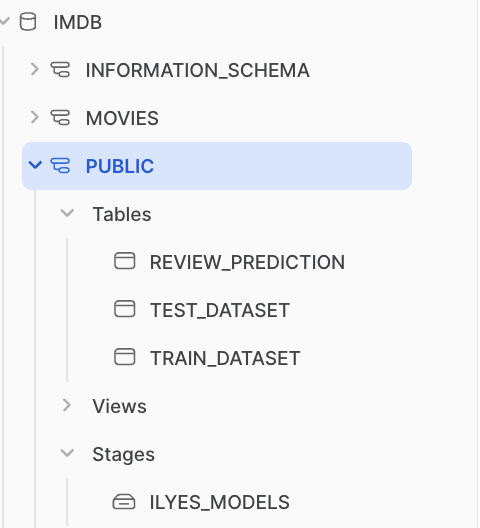

In [1]:
from IPython.display import Image

Image("../IMDB DB Snowflake.png")

### <a id='isection1'> Library import </a>

In [2]:
import numpy as np
import pandas as pd
from snowflake.snowpark import functions as fn
from snowflake.snowpark import version
from snowflake.snowpark.functions import col, sproc, udf
from snowflake.snowpark.session import Session
from snowflake.snowpark.types import (BooleanType, FloatType, IntegerType,
                                      StringType, Variant)

print(f"Snowflake snowpark version is : {version.VERSION}")

Snowflake snowpark version is : (0, 11, 0)


### <a id='section2'> Snowpark connexion </a>

In [3]:
import json

session = Session.builder.configs(json.load(open("../connection.json"))).create()
print(session.sql('select current_role(), current_warehouse(), current_database(), current_schema()').collect())

[Row(CURRENT_ROLE()='ACCOUNTADMIN', CURRENT_WAREHOUSE()='DEMO_WH', CURRENT_DATABASE()='IMDB', CURRENT_SCHEMA()='PUBLIC')]


#### Import the needed package into the Snowpark session

In [4]:
session.clear_imports()
session.clear_packages()

session.add_packages("snowflake-snowpark-python")
session.add_packages("scikit-learn", "pandas", "numpy", "nltk", "joblib", "cachetools")

In [5]:
cwh = "DEMO_WH"
cmd = "alter warehouse " + cwh + " suspend"
session.sql(cmd).collect()

[Row(status='Statement executed successfully.')]

In [6]:
#session.sql("SELECT * FROM PUBLIC. STAGE IF NOT EXISTS models").collect()
train_dataset_name="TRAIN_DATASET"
train_dataset = session.table(train_dataset_name)
train_dataset.show()

--------------------------------------------------------------------
|"REVIEW"                                            |"SENTIMENT"  |
--------------------------------------------------------------------
|"I really liked this movie. If other people wan...  |positive     |
|"Robin Williams and Kurt Russell play guys in t...  |positive     |
|"Got this the other day from the Creators on DV...  |positive     |
|"I guess I am coming late to the party. I just ...  |negative     |
|"I recently rented this video after seeing ""Fi...  |positive     |
|"My first question after seeing this film was, ...  |negative     |
|"Rise of the Undead starts as some huge nuclear...  |negative     |
|"One of the best parts of Sundance is seeing mo...  |positive     |
|"Jane Eyre has always been my favorite novel! W...  |positive     |
|"I saw this cinematic wretchedness in a dollar ...  |negative     |
--------------------------------------------------------------------



In [7]:
train_dataset.where(train_dataset["SENTIMENT"].isNotNull() == False).show()

--------------------------
|"REVIEW"  |"SENTIMENT"  |
--------------------------
|          |             |
--------------------------



In [8]:
train_dataset_flag = train_dataset.withColumn("SENTIMENT_FLAG", fn.when(train_dataset.SENTIMENT == "positive", 1)
                                     .otherwise(2))

### <a id='section3'> Training model </a>

#### Create a stage to store the model

In [9]:
session.sql("CREATE STAGE IF NOT EXISTS models").collect()

[Row(status='MODELS already exists, statement succeeded.')]

In [10]:
import io

import joblib


def save_file(session, model, path):
    input_stream = io.BytesIO()
    joblib.dump(model, input_stream)
    session._conn._cursor.upload_stream(input_stream, path)
    
    return "successfully created file: " + path

#### Train function

In [11]:
def train_model_review_pipline(session : Session, train_dataset_name: str) -> Variant:
    
    import os

    import sklearn.feature_extraction.text as txt
    from joblib import dump
    from nltk.corpus import stopwords
    from sklearn import svm
        
    train_dataset = session.table(train_dataset_name)
    train_dataset_flag = train_dataset.withColumn("SENTIMENT_FLAG", fn.when(train_dataset.SENTIMENT == "positive", 1)
                                     .otherwise(2))
    nb_record = train_dataset_flag.count()
    train_x = train_dataset_flag.toPandas().REVIEW.values
    train_y = train_dataset_flag.toPandas().SENTIMENT_FLAG.values
    print('Taille train x : ', len(train_x))
    print('Taille train y : ', len(train_y))
    
    print('Configuring parameters ...')
    # bags of words: parametrage
    analyzer = 'word' # {‘word’, ‘char’, ‘char_wb’}
    ngram_range = (1,2) # unigrammes
    languages = ['english']
    lowercase = True
    token = "[\\w']+\\w\\b" #
    max_df=0.02    #50. * 1./len(train_x)  #default
    min_df=1 * 1./len(train_x) # on enleve les mots qui apparaissent moins de 1 fois
    max_features = 100000
    binary=True # presence coding
    strip_accents = 'ascii' #  {‘ascii’, ‘unicode’, None}
    
    svm_max_iter = 100
    svm_c = 1.8
    
    print('Building Sparse Matrix ...')
    vec = txt.CountVectorizer(
        #encoding='latin1', \
        #strip_accents=strip_accents, \
        #lowercase=lowercase, \
        #preprocessor=process, \
        #tokenizer=token,\
        #stop_words=stop_words, \
        token_pattern=token, \
        ngram_range=ngram_range, \
        analyzer=analyzer,\
        max_df=max_df, \
        min_df=min_df, \
        #max_features=max_features, \
        vocabulary=None, 
        binary=binary)

    # pres => normalisation
    bow = vec.fit_transform(train_x)
    #transformer = txt.TfidfTransformer()
    #bow = transformer.fit_transform(bow)
    print('Taille vocabulaire : ', len(vec.get_feature_names_out()))
    
    print('Fitting model ...')
    model = svm.LinearSVC(C=svm_c, max_iter=svm_max_iter)
    print(model.fit(bow, train_y))
    
    # Upload the Vectorizer (BOW) to a stage
    print('Upload the Vectorizer (BOW) to a stage')
    session.sql('create stage if not exists models').collect()
    model_output_dire = '/tmp'
    model_file = os.path.join(model_output_dire, 'vect_review.joblib')
    dump(vec, model_file, compress=True)
    session.file.put(model_file, "@models", auto_compress=True, overwrite=True)
    
    # Upload trained model to a stage
    print('Upload trained model to a stage')
    session.sql('create stage if not exists models').collect()
    model_output_dire = '/tmp'
    model_file = os.path.join(model_output_dire, 'model_review.joblib')
    dump(model, model_file, compress=True)
    session.file.put(model_file, "@models", auto_compress=True, overwrite=True)
    
    return {"STATUS": "SUCCESS", "R2 Score Train": str(model.score(bow, train_y))}

In [12]:
%%time

# train_model_review_pipline(session, train_dataset_name="TRAIN_DATASET")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


### <a id='section4'> Push the training sequence into Snowflake using a Store Procedure </a>

In [13]:
%%time

session.sproc.register(func=train_model_review_pipline, name="train_model_review_pipline", replace=True)

CPU times: user 35.7 ms, sys: 10.5 ms, total: 46.3 ms
Wall time: 19.5 s


### <a id='section44'> Call the Store Procedure to train the model </a>

In [14]:
%%time

session.call("train_model_review_pipline", "TRAIN_DATASET")

# CPU times: user 16.5 ms, sys: 35.9 ms, total: 52.4 ms
# Wall time: 1min 28s

CPU times: user 36.1 ms, sys: 10.2 ms, total: 46.3 ms
Wall time: 1min 35s


'{\n  "R2 Score Train": "1.0",\n  "STATUS": "SUCCESS"\n}'

#### Import the needed files from the stage

In [15]:
session.add_import("@models/model_review.joblib")
session.add_import("@models/vect_review.joblib")

#### Function to load the model from the Internal Stage (Snowflake)

In [16]:
import cachetools


@cachetools.cached(cache={})
def load_file(filename):
    
    import os
    import sys

    import joblib
    
    import_dir = sys._xoptions.get("snowflake_import_directory")
    
    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

### <a id='section5'> Deploy an UDF for prediction </a>

In [17]:
%%time

@udf(name='predict_review',is_permanent = False, stage_location = '@models', replace=True)
def predict_review(args: list) -> float:
    
    import sys

    import pandas as pd
    from joblib import load

    model = load_file("model_review.joblib")
    vec = load_file("vect_review.joblib")
        
    features = list(["REVIEW", "SENTIMENT_FLAG"])
    
    row = pd.DataFrame([args], columns=features)
    bowTest = vec.transform(row.REVIEW.values)
    
    return model.predict(bowTest)

CPU times: user 245 ms, sys: 53.1 ms, total: 298 ms
Wall time: 10.7 s


### <a id='section6'> Prediction </a>

#### Using Python

In [18]:
test_dataset = session.table("TEST_DATASET")
new_df = test_dataset.withColumn("SENTIMENT_FLAG", fn.when(test_dataset.SENTIMENT == "positive", 1)
                                     .otherwise(2))
print(new_df.count())
new_df.show()

10372
---------------------------------------------------------------------------------------
|"REVIEW"                                            |"SENTIMENT"  |"SENTIMENT_FLAG"  |
---------------------------------------------------------------------------------------
|aking this film into a monumental success simpl...  |negative     |2                 |
|"I remember seeing this film years ago on, I th...  |positive     |1                 |
|"A truly masterful piece of filmmaking. It mana...  |negative     |2                 |
|"Terrible. There's no way to get around it. A s...  |negative     |2                 |
|"Take a few dark and stormy nights, fog coming ...  |negative     |2                 |
|"I enjoyed the beautiful scenery in this movie ...  |negative     |2                 |
|"*********Ten out of Ten Stars********* <br /><...  |positive     |1                 |
|"This film was total rubbish. I was sitting wat...  |negative     |2                 |
|"Lady and the Tramp II: S

In [19]:
%%time

new_df.select(new_df.REVIEW, new_df.SENTIMENT, new_df.SENTIMENT_FLAG,\
              fn.call_udf("predict_review", fn.array_construct(col("REVIEW"), col("SENTIMENT_FLAG"))).alias('PREDICTED_REVIEW')) \
        .show()

------------------------------------------------------------------------------------------------------------
|"REVIEW"                                            |"SENTIMENT"  |"SENTIMENT_FLAG"  |"PREDICTED_REVIEW"  |
------------------------------------------------------------------------------------------------------------
|aking this film into a monumental success simpl...  |negative     |2                 |2.0                 |
|"I remember seeing this film years ago on, I th...  |positive     |1                 |1.0                 |
|"A truly masterful piece of filmmaking. It mana...  |negative     |2                 |2.0                 |
|"Terrible. There's no way to get around it. A s...  |negative     |2                 |2.0                 |
|"Take a few dark and stormy nights, fog coming ...  |negative     |2                 |2.0                 |
|"I enjoyed the beautiful scenery in this movie ...  |negative     |2                 |2.0                 |
|"*********Ten out 

#### Using SQL

In [20]:
session.sql("CREATE OR REPLACE VIEW PUBLIC.VIEW_TEST_DATASET_FLAH AS \
            SELECT \
                REVIEW, \
                SENTIMENT, \
                CASE \
                    WHEN (SENTIMENT = 'positive') THEN 1 :: bigint \
                    ELSE 2 :: bigint \
                END AS SENTIMENT_FLAG \
            FROM \
                TEST_DATASET").collect()

[Row(status='View VIEW_TEST_DATASET_FLAH successfully created.')]

In [21]:
%%time

session.sql(' select REVIEW, SENTIMENT, SENTIMENT_FLAG, \
            predict_review(ARRAY_CONSTRUCT( \
                                    REVIEW, \
                                    SENTIMENT_FLAG)) as PREDICTED_REVIEW \
                                    from VIEW_TEST_DATASET_FLAH').show()

------------------------------------------------------------------------------------------------------------
|"REVIEW"                                            |"SENTIMENT"  |"SENTIMENT_FLAG"  |"PREDICTED_REVIEW"  |
------------------------------------------------------------------------------------------------------------
|aking this film into a monumental success simpl...  |negative     |2                 |2.0                 |
|"I remember seeing this film years ago on, I th...  |positive     |1                 |1.0                 |
|"A truly masterful piece of filmmaking. It mana...  |negative     |2                 |2.0                 |
|"Terrible. There's no way to get around it. A s...  |negative     |2                 |2.0                 |
|"Take a few dark and stormy nights, fog coming ...  |negative     |2                 |2.0                 |
|"I enjoyed the beautiful scenery in this movie ...  |negative     |2                 |2.0                 |
|"*********Ten out 

In [22]:
session.sql(' select REVIEW, SENTIMENT, SENTIMENT_FLAG, \
            predict_review(ARRAY_CONSTRUCT( \
                                    REVIEW, \
                                    SENTIMENT_FLAG)) as PREDICTED_REVIEW \
                                    from VIEW_TEST_DATASET_FLAH').toPandas().head()

REVIEW SENTIMENT  \
0  "Having first read the novel, I don't mind,for...  negative   
1  "Sometimes, when seeking a movie nothing will ...  positive   
2  "I have been a fan of Without A Trace from the...  negative   
3  "Many questions arise about the making of this...  negative   
4  "I'll just be vague about my potential spoilin...  negative   

   SENTIMENT_FLAG  PREDICTED_REVIEW  
0               2               2.0  
1               1               1.0  
2               2               2.0  
3               2               2.0  
4               2               2.0

### <a id='section7'> Push the prediction into Snowflake </a>

#### Using SQL (Table : REVIEW_PREDICTION)

#### Using Python (Table : REVIEW_PREDICTION)

In [23]:
%%time

new_df.select(new_df.REVIEW, new_df.SENTIMENT, new_df.SENTIMENT_FLAG,\
              fn.call_udf("predict_review", fn.array_construct(col("REVIEW"), col("SENTIMENT_FLAG"))).alias('PREDICTED_REVIEW')) \
        .write.mode('overwrite').saveAsTable('review_prediction')

CPU times: user 9.55 ms, sys: 2.24 ms, total: 11.8 ms
Wall time: 18 s


#### Compare the target label with the predicted one

In [24]:
session.sql("SELECT * FROM REVIEW_PREDICTION WHERE SENTIMENT_FLAG <> PREDICTED_REVIEW").show()

------------------------------------------------------------------
|"REVIEW"  |"SENTIMENT"  |"SENTIMENT_FLAG"  |"PREDICTED_REVIEW"  |
------------------------------------------------------------------
|          |             |                  |                    |
------------------------------------------------------------------



#### Close Snowpark session

In [25]:
session.close()